In [6]:
# Implementation of CycleGAN Network

In [7]:
# For importing Generator & Discriminator, We need to install tensorflow_examples
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-j50k_ene
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-j50k_ene
  Resolved https://github.com/tensorflow/examples.git to commit 2741d0f2a345ef52e0de1d498de732f5dacbf2f0
  Preparing metadata (setup.py) ... done


In [8]:
import tensorflow as tf
tf.version.VERSION

'2.13.0'

In [9]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [10]:
# Download the CMP Facade Database data (30MB)
# Each original image is of size 256 x 512 containing two 256 x 256 images:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"facades.tar.gz",
    origin=_URL,
    extract=True)

In [11]:
path_to_zip

'/root/.keras/datasets/facades.tar.gz'

In [12]:
import pathlib
path_to_zip  = pathlib.Path(path_to_zip)
path_to_zip

PosixPath('/root/.keras/datasets/facades.tar.gz')

In [13]:
path_to_zip.parent

PosixPath('/root/.keras/datasets')

In [14]:
PATH = path_to_zip.parent/"facades"
PATH

PosixPath('/root/.keras/datasets/facades')

In [15]:
sample_image = tf.io.read_file(str(PATH / 'train/19.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


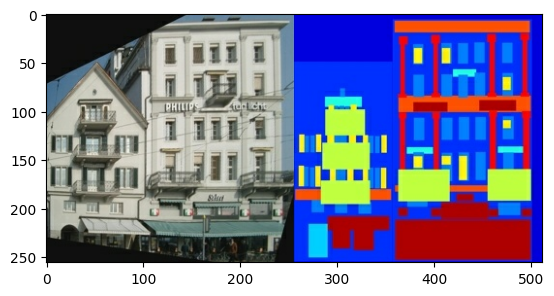

In [16]:
# We will need to separate real building facade images from the architecture label
# images—all of which will be of size 256 x 256.
plt.figure()
plt.imshow(sample_image)

In [17]:
# load image
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

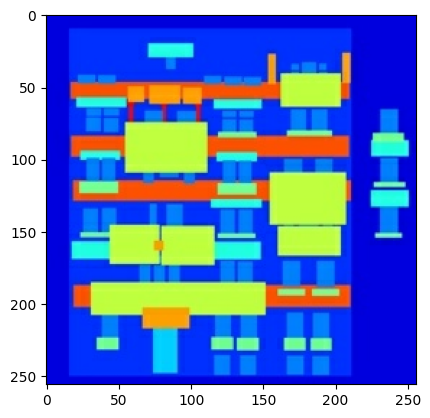

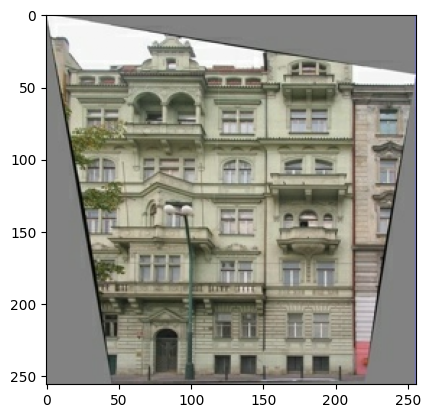

In [18]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [19]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net based Generator
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [20]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [21]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [22]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [23]:
@tf.function()
def random_jitter(input_image, real_image):
  # In random jittering, the image is resized to 286 x 286 and
  # then randomly cropped to 256 x 256.
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [24]:
# Get all the images file path
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))

In [25]:
train_dataset

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [26]:
# total number of images for training
len(train_dataset)

400

In [27]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [28]:
train_image_list = []
train_mask_list = []

In [29]:
for x in train_dataset.as_numpy_iterator():
  image, mask = load_image_train(x)
  train_image_list.append(image)
  train_mask_list.append(mask)

In [30]:
len(train_image_list)

400

In [31]:
# Create Dataset object for data input pipeline in Tensor
image_dataset_train = tf.data.Dataset.from_tensor_slices(train_image_list)
mask_dataset_train = tf.data.Dataset.from_tensor_slices(train_mask_list)

In [32]:
# creating tensorflow input pipeline for real houses as well as its architectural drawing
train_houses_arch = image_dataset_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_houses_draw = mask_dataset_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [33]:
sample_house = next(iter(train_houses_arch))
real_house = next(iter(train_houses_draw))

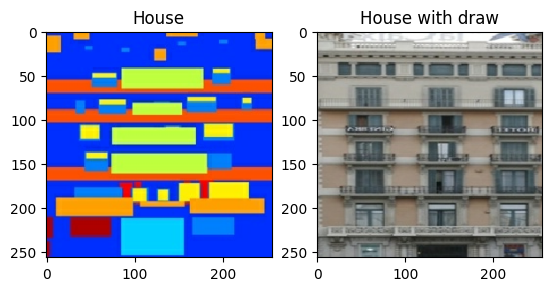

In [34]:
plt.subplot(121)
plt.title('House')
plt.imshow(sample_house[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('House with draw')
plt.imshow((real_house[0]) * 0.5 + 0.5)

In [35]:
# model building
# The model architecture used in this tutorial is very similar to what was used
# in pix2pix. Some of the differences are:

# Cyclegan uses instance normalization instead of batch normalization.
# The CycleGAN paper uses a modified resnet based generator. But We will be using
# a modified unet generator for simplicity.

OUTPUT_CHANNELS = 3

# generator_g = image "real house" to image "architecture draw house"
# generator_f = image "architecture draw house" to image "real house"
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# discriminator_x = To differentiate b/w image "real house" and generated image "real house" (F(Y))
# discriminator_y = To differentiate b/w image "architecture draw house" and
# generated image "architecture draw house" (F(Y)) from real house.
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

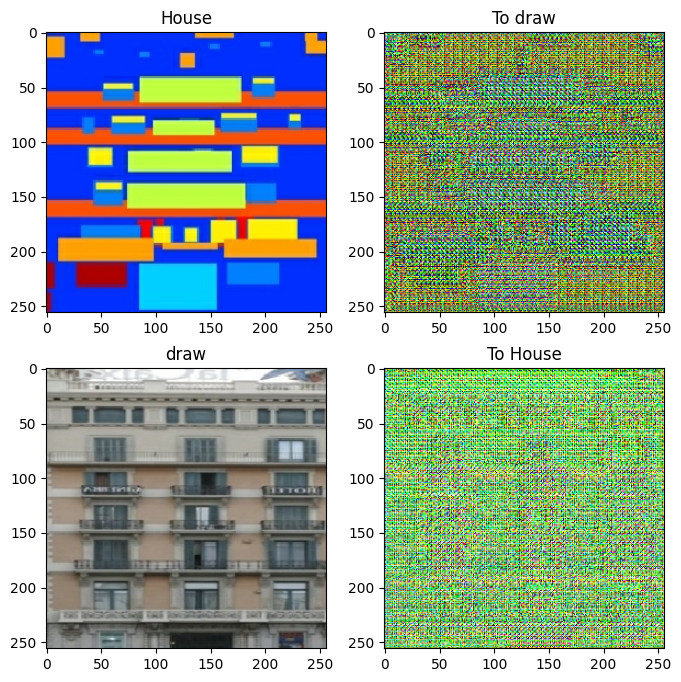

In [36]:
to_draw = generator_g(sample_house)
to_house = generator_f(real_house)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_house, to_draw, sample_draw, to_house]
title = ['House', 'To draw', 'draw', 'To House']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

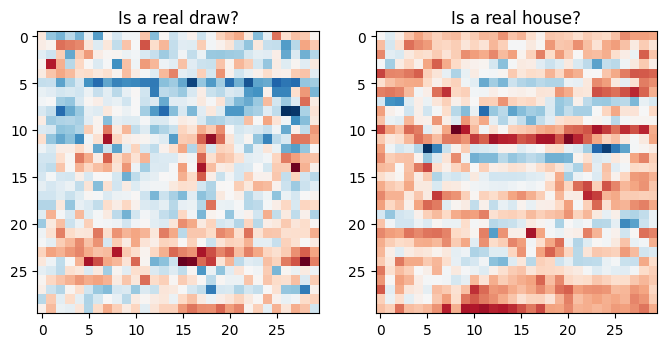

In [37]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real draw?')
plt.imshow(discriminator_y(real_house)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real house?')
plt.imshow(discriminator_x(sample_house)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [38]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [39]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [40]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [41]:
# Cycle consistency means the result should be close to the original input.
# For example, if one translates a sentence from English to French, and then translates
# it back from French to English, then the resulting sentence should be the same
# as the original sentence.

# In cycle consistency loss,

# 1. Image X is passed via generator G that yields generated image Y.
# 2. Generated image Y is passed via generator F that yields cycled image X.
# 3. Mean absolute error is calculated between real X and cycled X.
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [42]:
# Accourding to Identity preservation, we also calculate Identity loss.
# If you run the real-to-architecture house model on a real house or the
# architecture-to-real house model on a architecture house, it should not modify
# the image much since the image already contains the target class.

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [43]:
# define the optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [44]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [45]:
# EPOCHS has been kept small as it needs very high computation power.
# The generated images will have much lower quality.
EPOCHS = 10

In [46]:
# Generating images from trained model
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [47]:
# per epoch training step as per concept of CycleGAN
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

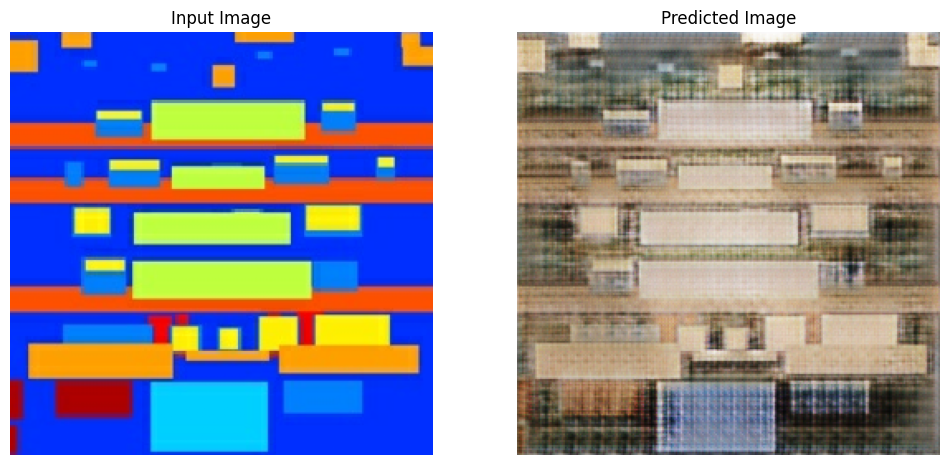

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Time taken for epoch 10 is 181.66421103477478 sec



In [48]:
# running training loops over training datasets
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_houses_arch, train_houses_draw)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_house) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_house)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

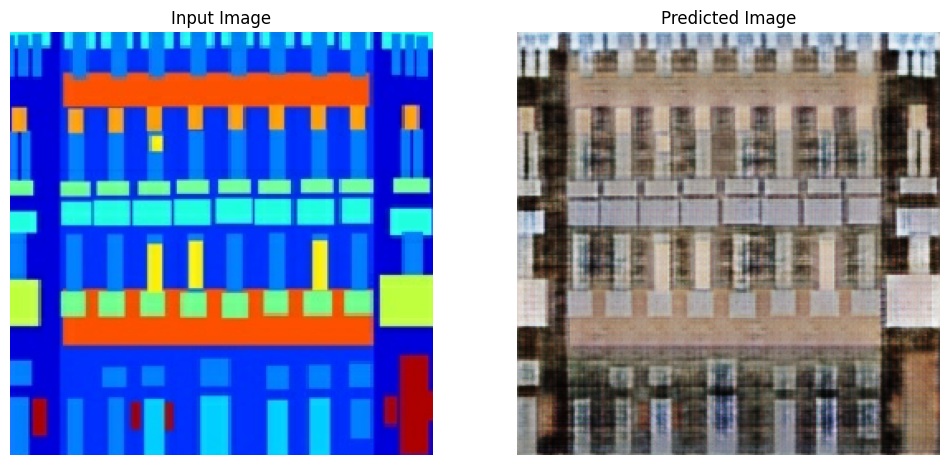

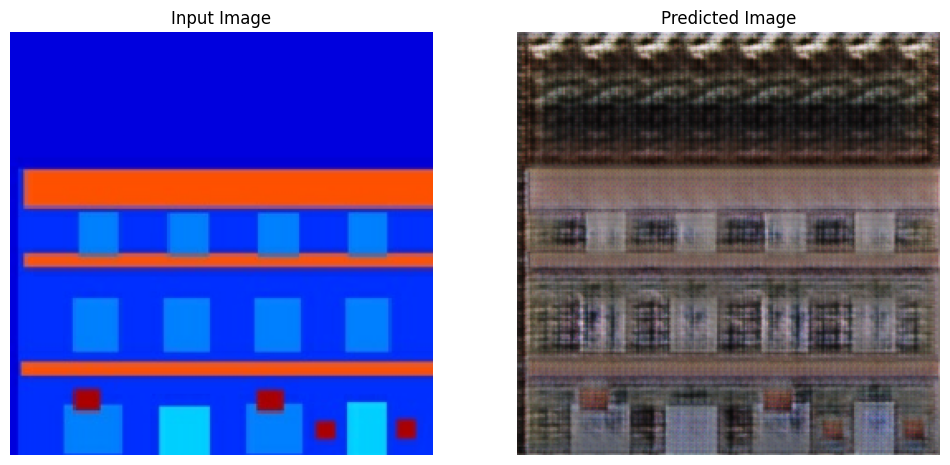

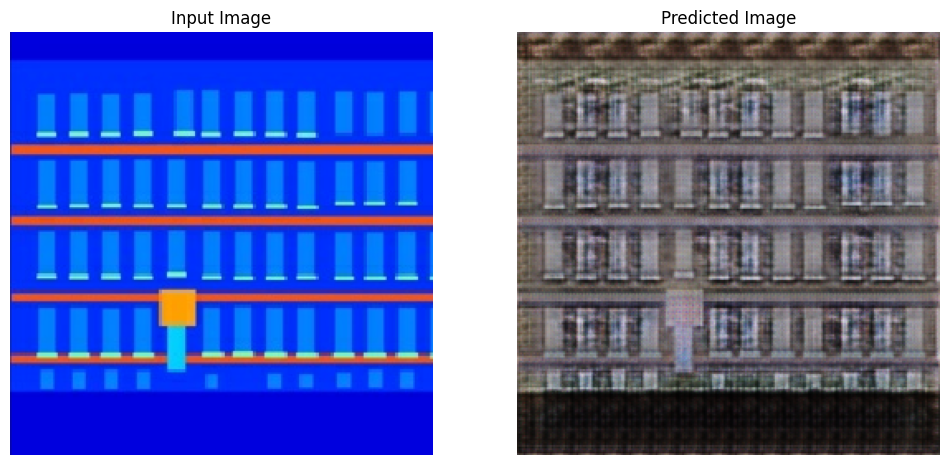

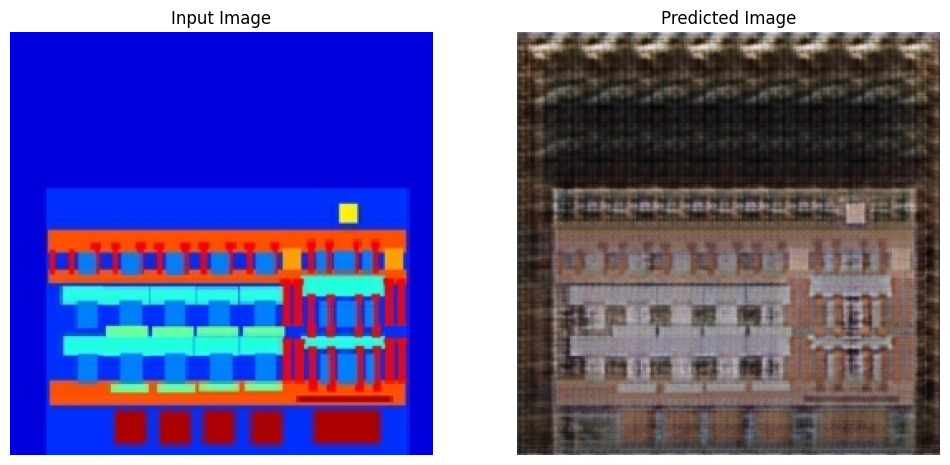

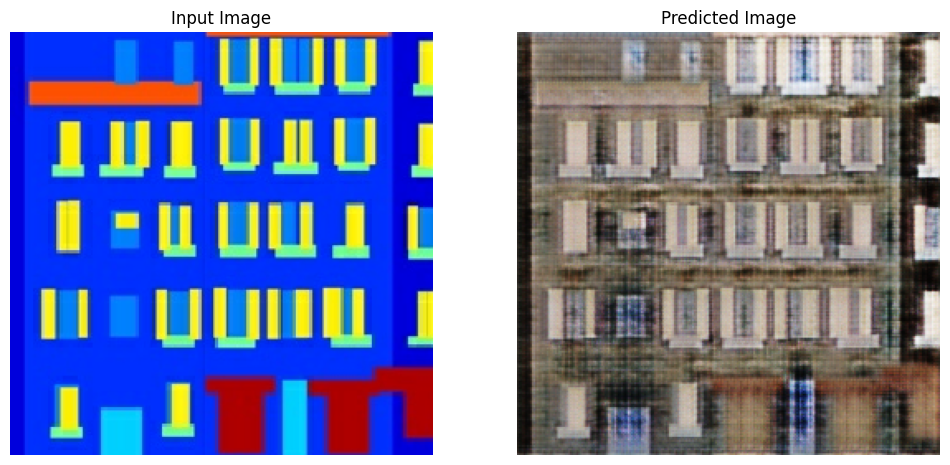

In [50]:
# Predicting image generation of trained style transferring model
for imgs in train_houses_arch.take(5):
  generate_images(generator_g, imgs)